## Clustering and functional analysis on Bayesian timescales
Author: Robert Ietswaart  
Date: 20220713  
License: BSD2.  
Load modules j3dl and activate virtual environment using j4RNAdecay on O2.  
Python v3.7.4

Source: `Function_20220311.ipynb`  
For RNA flow project. 

In [1]:
import os
import re
import copy
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import logging
import argparse
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import seaborn as sns


# from __init__ import __version__
from __init__ import default_logger_format, default_date_format

In [2]:
# def main():
np.random.seed(12345)

parser = argparse.ArgumentParser(
    description='Estimating the fraction of transcripts that get nuclear degraded, ' 
                'through production rate estimates kp.')

args = parser.parse_args("")#EDIT: added "" as argument to run in ipynb instead of .py script

In [6]:
path = os.path.join('/n','groups','churchman','ri23','bseq','KP20220713')

# Add a logger specific to the project and processing stage
logger = logging.getLogger('KP')
log_file = os.path.join(path,'LogErr', 'KP_20220713.log')
formatter = logging.Formatter(default_logger_format,
                              datefmt=default_date_format)
log_handler = logging.FileHandler(log_file)
log_handler.setFormatter(formatter)
logger.addHandler(log_handler)

organisms = ['m','h']
org_map = {'m': 'mouse', 'h': 'human'}
org_red_reps = {'m': ['G_R','H_S'], 'h': ['T', 'U']}
reps = ['G','H','R','S','T','U']
red_r = {'G': 'G_R', 'H': 'H_S', 'R': 'G_R', 'S': 'H_S', 'T': 'T', 'U': 'U'}
fracs = ['chr', 'nuc', 'cyto', 'poly', 'tot']
k_bound_lo = 1e-4 #unit: min^-1: 1 per 7 days
k_bound_hi = 1e4 #unit: min^-1: 1 per 6 ms

RATE_TYPE = ['half_life_','k_','T_']

rt = RATE_TYPE[1] #ML model dependent variable: rates

Timescales = ['chr',
              'nuc',
              'nucexp_from_chr',
              'nucdeg',
              'cyto',
              'poly_entry',
              'whole_cell',
              'nucexp_from_nucdeg']
Timescales = [rt + ts for ts in Timescales]
TC_TYPES = ['top1000','bottom500']#BM model turnover method to estimate TC
OUT_TYPES = ['.Mean', '.MAP', '.0.975.quantile', '.0.025.quantile']


kp_compartment = 'chromatin' #'wc' #
kp_ot = '_Mean' #'_MAP' #

B = dict()          #Bayes fits file
K = dict()          #Bayes Factor
P = dict()
GS = dict()         #GRAND-SLAM

for o in organisms:  
    GS[o] = dict()   
    if o == 'm':
        path_gs = os.path.join('/n','groups','churchman','ri23','bseq','GS20210506')
        path_b = os.path.join('/n','groups','churchman','ri23','bseq','Bayes20220222')
        filename_b = 'Bayes20220228.tsv'   
    elif o == 'h':
        path_gs = os.path.join('/n','groups','churchman','ri23','bseq','GS20210713_human')
        path_b = os.path.join('/n','groups','churchman','ri23','bseq','Bayes20220228_human')
        filename_b = 'Bayes20220228_human.tsv'
    path_k = os.path.join('/n','groups','churchman','ri23','bseq','BayesFactor20220307')
    filename_k = 'Bayes_factor_20220315_' + org_map[o] + '.tsv'

    B[o] = pd.read_csv(os.path.join(path_b, filename_b), sep='\t')
    K[o] = pd.read_csv(os.path.join(path_k, filename_k), sep='\t')
    
    for r in reps:
        for fr in fracs:
            for tc in TC_TYPES:
                filename_gs = r + '_' + fr + '_noMT_' + tc + '.csv'
                if os.path.exists(os.path.join(path_gs, filename_gs)):
                    GS[o][red_r[r]+fr+tc]= pd.read_csv(os.path.join(path_gs, filename_gs) ,index_col=0)

    for i, rr in enumerate(org_red_reps[o]):
        if o == 'm':
            filename = kp_compartment+'_kp_rep'+str(i+1)+'_'+org_map[o]+kp_ot+'.txt'  
        elif o == 'h':
            filename = kp_compartment+'_kp_rep'+str(i+1)+kp_ot+'.txt' 
        P[rr] = pd.read_csv(os.path.join(path, filename), sep='\t')
        mapper = {'kp':rr+'.kp', 'type':rr+'.type'}
        P[rr].rename(mapper=mapper, axis=1, inplace=True)

### Preprocess rates: dependent variables in model
- preprocess nucexp: nucexp_from_chr or nucexp_from_nucdeg depending on nucdeg no or yes 
- clip to domain bounds

In [6]:
T_bf = 100

C = copy.deepcopy(B)
for o in organisms:
    C[o] = C[o].merge(K[o], on='Gene', how='outer', suffixes=('', '_bf'))
    
    for rr in org_red_reps[o]:
        C[o] = C[o].merge(P[rr], on='Gene', how='outer', suffixes=('', '_'+rr))

    if o == 'h' and kp_ot == '_Mean' and kp_compartment == 'chromatin':
        C[o] = C[o][~C[o]['Symbol'].isin({'TMPO'})]#artefactually fast rate for Mean rep2; seems only outlier 
        
    logger.info('%s all genes: %d' % (org_map[o], len(C[o])))

    
    for ot in OUT_TYPES:
        for rr in org_red_reps[o]:
            ts = rt+'nucexp_from_chr'
            C[o][rr+'.'+ts+ot].where(((C[o][rr+'.bayes_factor'] <= T_bf) | (C[o][rr+'.bayes_factor'].isna())), 
                                     C[o][rr+'.'+rt+'nucexp_from_nucdeg'+ot], inplace=True)                        
            ts = rt+'nucdeg'
            C[o][rr+'.'+ts+ot].where(C[o][rr+'.bayes_factor'] > T_bf, np.nan, inplace=True)


            for ts in Timescales:

                ###Clip range of values beyond numerical integration domain bounds                  
                C[o][rr+'.'+ts+ot].where(((C[o][rr+'.'+ts+ot] > k_bound_lo) | (C[o][rr+'.'+ts+ot].isna())), 
                                         k_bound_lo, inplace=True) 
                C[o][rr+'.'+ts+ot].where(((C[o][rr+'.'+ts+ot] < k_bound_hi) | (C[o][rr+'.'+ts+ot].isna())), 
                                         k_bound_hi, inplace=True)  


INFO: [2022-07-19 16:21:16] KP - mouse all genes: 17584
INFO: [2022-07-19 16:21:16] KP - human all genes: 18154


### Calculate fraction of degraded transcripts

In [7]:
ot = kp_ot.replace('_','.') 
    
for o in organisms:
    for rr in org_red_reps[o]:
        C[o][rr+'.kp_ND'] = C[o][rr+'.kp'] * C[o][rr+'.k_nucdeg'+ot] / \
                            (C[o][rr+'.k_nucdeg'+ot] + C[o][rr+'.k_nucexp_from_chr'+ot])
        
        C[o][rr+'.frac_ND'] = C[o][rr+'.kp_ND'] / C[o][rr+'.kp']

## Standard PUNDs criteria

In [8]:
logger.info('kp derived from compartment: %s with %s' % (kp_compartment, ot))


for o in organisms:
    rr1 = org_red_reps[o][0]
    
    global_kp_nd = C[o][C[o][rr1+'.type']=='yes'][[rr+'.kp_ND' for rr in org_red_reps[o]]].sum().sum()
    frac_nd_of_all = global_kp_nd / C[o][[rr+'.kp' for rr in org_red_reps[o]]].sum().sum()
    logger.info('%s fraction of transcripts nucdegraded over all produced protein-coding transcripts: %s' % (o,frac_nd_of_all))
    frac_nd_of_PUNDs = global_kp_nd / C[o][C[o][rr1+'.type']=='yes'][[rr+'.kp' for rr in org_red_reps[o]]].sum().sum()
    logger.info('%s fraction of transcripts nucdegraded over all produced PUND transcripts: %s' % (o,frac_nd_of_PUNDs))

for o in organisms:    
    for rr in org_red_reps[o]:
        median_frac_nd = C[o][C[o][rr+'.type']=='yes'][rr+'.frac_ND'].median()
        logger.info('%s %s median (over gene distribution) of fraction of nucdegraded transcripts: %s' % 
                    (o,rr,median_frac_nd))    
    

INFO: [2022-07-19 16:21:26] KP - kp derived from compartment: chromatin with .Mean
INFO: [2022-07-19 16:21:26] KP - m fraction of transcripts nucdegraded over all produced protein-coding transcripts: 0.3485254631051543
INFO: [2022-07-19 16:21:26] KP - m fraction of transcripts nucdegraded over all produced PUND transcripts: 0.9710930253351452
INFO: [2022-07-19 16:21:26] KP - h fraction of transcripts nucdegraded over all produced protein-coding transcripts: 0.19988820137287683
INFO: [2022-07-19 16:21:26] KP - h fraction of transcripts nucdegraded over all produced PUND transcripts: 0.9540442505577207
INFO: [2022-07-19 16:21:26] KP - m G_R median (over gene distribution) of fraction of nucdegraded transcripts: 0.9790992583186715
INFO: [2022-07-19 16:21:26] KP - m H_S median (over gene distribution) of fraction of nucdegraded transcripts: 0.9810668430334458
INFO: [2022-07-19 16:21:26] KP - h T median (over gene distribution) of fraction of nucdegraded transcripts: 0.9784826130861547
INFO

#### Distribution over PUND genes of fraction nuclear degraded RNA 

In [6]:
logger.info('kp derived from compartment: %s with %s' % (kp_compartment, ot))

for o in organisms:
    for rr in org_red_reps[o]: 
        df = C[o][~C[o][rr+'.k_nucdeg'+ot].isna()]
        global_kp_nd = df[rr+'.kp_ND'].sum()
        frac_nd_of_all = global_kp_nd / C[o][rr+'.kp'].sum()
        logger.info('%s %s fraction of transcripts nucdegraded over all '
                    'produced protein-coding transcripts: %s' % (o,rr,frac_nd_of_all.round(2)))
        frac_nd_of_PUNDs = global_kp_nd / df[rr+'.kp'].sum()
        logger.info('%s %s fraction of transcripts nucdegraded over all '
                    'produced PUND transcripts: %s' % (o,rr,frac_nd_of_PUNDs.round(2)))


for o in organisms:
    for rr in org_red_reps[o]:   
        df = C[o][~C[o][rr+'.k_nucdeg'+ot].isna()]
        median_frac_nd = df[rr+'.frac_ND'].median().round(2)
        logger.info('%s %s median (over gene distribution) of fraction of nucdegraded transcripts: %s' % 
                    (o,rr,median_frac_nd))    
    

INFO: [2022-07-15 10:37:54] KP - kp derived from compartment: chromatin with .Mean
INFO: [2022-07-15 10:37:54] KP - m G_R fraction of transcripts nucdegraded over all produced protein-coding transcripts: 0.42
INFO: [2022-07-15 10:37:54] KP - m G_R fraction of transcripts nucdegraded over all produced PUND transcripts: 0.97
INFO: [2022-07-15 10:37:54] KP - m H_S fraction of transcripts nucdegraded over all produced protein-coding transcripts: 0.42
INFO: [2022-07-15 10:37:54] KP - m H_S fraction of transcripts nucdegraded over all produced PUND transcripts: 0.91
INFO: [2022-07-15 10:37:54] KP - h T fraction of transcripts nucdegraded over all produced protein-coding transcripts: 0.27
INFO: [2022-07-15 10:37:54] KP - h T fraction of transcripts nucdegraded over all produced PUND transcripts: 0.96
INFO: [2022-07-15 10:37:54] KP - h U fraction of transcripts nucdegraded over all produced protein-coding transcripts: 0.26
INFO: [2022-07-15 10:37:54] KP - h U fraction of transcripts nucdegrade

INFO: [2022-07-15 10:43:40] KP - Bayes Factor 100


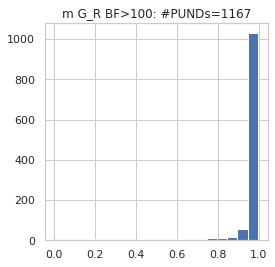

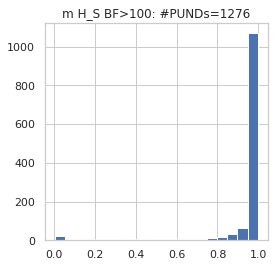

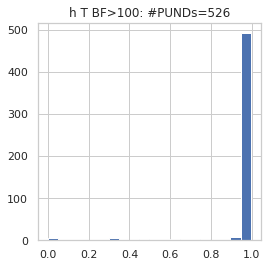

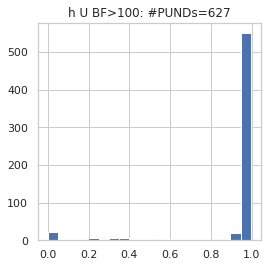

In [12]:
logger.info('Bayes Factor %d' % T_bf)
for o in organisms:
    for rr in org_red_reps[o]:  
        df = C[o][~C[o][rr+'.k_nucdeg'+ot].isna()]
        sns.set(style="whitegrid", color_codes=True,font_scale=1)
        f, ax = plt.subplots(figsize=(4, 4)) 
        df[rr+'.frac_ND'].hist(bins=20)
        plt.title(o+' '+rr+' BF>'+str(T_bf)+': #PUNDs='+str(len(df)))
        